In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import jax_moseq
import jax, jax.numpy as jnp, jax.random as jr
from jax_moseq.models.allo_dynamics import generate_states

### Simulation

Simulate an agent with the following patterns of movement, with transitions occuring roughly once per 10 time steps

| Index | Name | $\Delta h$ | $\Delta v$ |
| -- | ---- | ---------- | ---------- |
| 0 | Forward walk | 0 | (1,0) |
| 1 | Left-curving walk | 0.1 | (1,0) |
| 2 | Right-curving walk | -0.1 | (1,0) |
| 3 | Hard left turn | 0.2 | (0.5,0) |
| 4 | Hard right turn | -0.2 | (0.5,0) |
| 5 | Shuffle left | 0 | (0.5,0.5) |
| 6 | Shuffle right | 0 | (0.5,-0.5) |



In [18]:
delta_v = jnp.array([[1,0],[1,0],[1,0],[0.5,0],[0.5,0],[0.5,.5],[0.5,-.5]])
delta_h = jnp.array([0,0.1,-0.1,0.2,-0.2,0,0])

sigmasq_v = jnp.ones(8) * 0.25**2
sigmasq_h = jnp.ones(8) * 0.05**2

pi = jnp.eye(7) * 0.9 + jnp.ones((7,7)) * 0.1/7

z_sim,h_sim,v_sim = generate_states(jr.PRNGKey(1), pi, delta_h, sigmasq_h, delta_v, sigmasq_v, 50000)

In [34]:
num_states = 20

allo_hypparams = {
    'alpha0_v':1, 'beta0_v':.1, 'lambda0_v':1,
    'alpha0_h':1, 'beta0_h':.1, 'lambda0_h':1, 
    'num_states':num_states
}

trans_hypparams = {
    'kappa':1000, 
    'alpha': 10, 
    'gamma':1000, 
    'num_states':num_states
}

hypparams = {
    'allo_hypparams':allo_hypparams,
    'trans_hypparams':trans_hypparams
}

In [35]:
from jax_moseq.models.allo_dynamics import init_model, resample_model, log_joint_likelihood

data = {'v':v_sim[None],'h':h_sim[None],'mask':jnp.ones(len(h_sim))[None]}
model = init_model(data=data, hypparams=hypparams)
ll = log_joint_likelihood(**data, **model['params'], **model['states'])
ll = {k:[v.item()] for k,v in ll.items()}

betas hash: 7d15bbb49d86d3bc06273b44b40839b897a4b1c9f2e3ae310d340db4ba0d7351
pi hash: 41401f2815a9b5581b31a1e27286cf696e230987a56c56ac640c75d7ea6ec277


In [36]:
import tqdm
for i in tqdm.trange(200):
    model = resample_model(data, **model)
    for k,v in log_joint_likelihood(**data, **model['params'], **model['states']).items(): 
        ll[k].append(v.item())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:29<00:00,  2.24it/s]


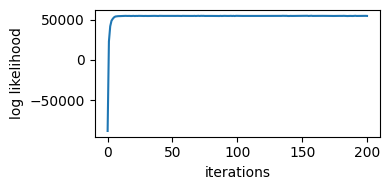

In [37]:
lls = np.array(ll['z'])+np.array(ll['hv'])
plt.plot(lls)
plt.gcf().set_size_inches((5,1.5))
plt.xlabel('iterations')
plt.ylabel('log likelihood')
plt.gcf().set_size_inches((4,2))
plt.tight_layout()
#plt.savefig('figs/allo_only_simulated/log_likelihood.png')

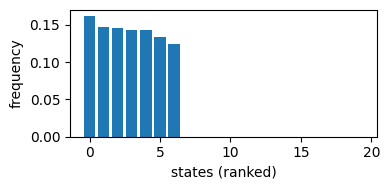

In [38]:
bc = np.bincount(np.array(model['states']['z']).flatten(),minlength=20)
plt.bar(np.arange(20),sorted(bc/bc.sum())[::-1])
plt.gcf().set_size_inches((4,2))
plt.xlabel('states (ranked)')
plt.ylabel('frequency')
plt.tight_layout()
#plt.savefig('figs/allo_only_simulated/frequency.png')

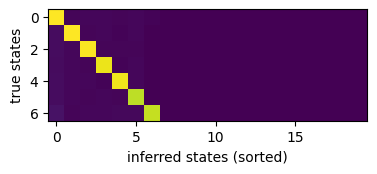

In [39]:
confusion = np.zeros((7,20))
for i,j in zip(z_sim,np.array(model['states']['z']).flatten()):
    confusion[i,j] += 1
o1 = np.argsort(bc)[::-1]
o2 = np.argsort(np.argmax(confusion[:,o1],axis=1))
plt.imshow(confusion[o2,:][:,o1])
plt.xlabel('inferred states (sorted)')
plt.ylabel('true states')
plt.gcf().set_size_inches((4,2))
plt.tight_layout()
#plt.savefig('figs/allo_only_simulated/confusion.png')

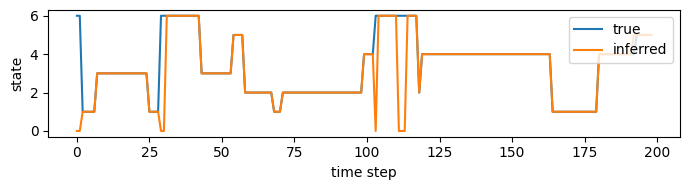

In [40]:
plt.plot(np.argsort(o2)[z_sim][1:200], label='true')
plt.plot(np.argsort(o1)[np.array(model['states']['z'][0])][:199], label='inferred')
plt.legend(loc='upper right')
plt.gcf().set_size_inches((7,2))
plt.ylabel('state')
plt.xlabel('time step')
plt.tight_layout()
#plt.savefig('figs/allo_only_simulated/real_vs_true_example.png')

(-516.1643829345703,
 -436.46372985839844,
 49.153577995300296,
 82.71128635406494)

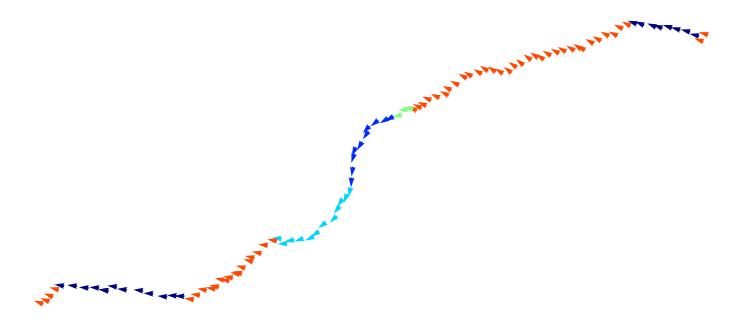

In [41]:
start,end = 6465, 6565
x = v_sim[start:end,0]
y = v_sim[start:end,1]
dx = np.cos(h_sim[start:end])*.02
dy = np.sin(h_sim[start:end])*.02
labels = z_sim[start:end]

cmap = plt.get_cmap('jet')
norm = mcolors.Normalize(vmin=0, vmax=6)
colors = cmap(norm(labels))

plt.quiver(x, y, dx, dy, color=colors, scale=1.5)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((12,4))
plt.gca().axis('off')
#plt.savefig('figs/allo_only_simulated/example_trajectory.pdf')